# Sentinel-1 SAR Data Retrieval with Sentinel Hub

This notebook demonstrates how to retrieve Sentinel-1 SAR (Synthetic Aperture Radar) data using the Sentinel Hub API. The data is downloaded based on a specified area of interest (AOI) defined in a GeoJSON file.

## Step 0: Install dependencies


In [81]:
%pip install geopandas sentinelhub python-dotenv matplotlib

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.3/8.3 MB 23.0 MB/s eta 0:00:0000:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.9/4.9 MB 18.3 MB/s eta 0:00:00ta 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.5/1.5 MB 6.1 MB/s eta 0:00:00
Note: you may need to restart the kernel to use updated packages.


## Step 1: Import Necessary Libraries

In [82]:
# Import necessary libraries

import geopandas as gpd
from sentinelhub import (
    CRS,
    BBox,
    DataCollection,
    MimeType,
    MosaickingOrder,
    SentinelHubRequest,
    SHConfig,
    bbox_to_dimensions,
)
import os
import matplotlib.pyplot as plt
from dotenv import load_dotenv

## Step 2: Load Environment Variables

In [71]:
load_dotenv()

True

## Step 3: Load Sentinel Hub Credentials

In this step, we configure the Sentinel Hub API credentials needed to authenticate requests.


In [72]:
# Load your Sentinel Hub credentials
config = SHConfig(
    sh_base_url="https://sh.dataspace.copernicus.eu",
    sh_token_url="https://identity.dataspace.copernicus.eu/auth/realms/CDSE/protocol/openid-connect/token",
    sh_client_id=os.getenv("sentinel_hub_client_id"),
    sh_client_secret=os.getenv("sentinel_hub_client_secret"),
)

## Step 4: Load the GeoJSON Area of Interest (AOI)

Here, we load the AOI from a GeoJSON file and extract its boundaries.


In [73]:
# Load the GeoJSON area of interest (AOI)
aoi = gpd.read_file("extraction_areas/mumbai_offshore.geojson")

# Convert the AOI to a bounding box (min_x, min_y, max_x, max_y format)
min_x, min_y, max_x, max_y = aoi.total_bounds
bbox = BBox(bbox=[min_x, min_y, max_x, max_y], crs=CRS.WGS84)  # type:ignore[arg-type]


## Step 5: Define Bounding Box Dimensions

In this step, we define the size of the bounding box area in pixels based on the desired resolution.


In [74]:
# Define the size of the bounding box area (in pixels)
bbox_size = bbox_to_dimensions(bbox, resolution=30)  # Adjust resolution as needed
print(f"BBox dimensions: {bbox_size}")

BBox dimensions: (1942, 1633)


## Step 6: Create a Sentinel Hub Request for SAR Data

Here, we configure the request for Sentinel-1 SAR data with the specified evaluation script.

In [75]:
# Create a request for Sentinel-1 SAR data (C-band, VV polarization)
request = SentinelHubRequest(
    data_folder="./downloads",  # Set your download directory
    evalscript="""
//VERSION=3
function setup() {
  return {
    input: ["VV"],  // Use VV polarization (C-band)
    output: { bands: 1 }
  };
}

function evaluatePixel(sample) {
  return [sample.VV];
}
""",
    input_data=[
        SentinelHubRequest.input_data(
            data_collection=DataCollection.SENTINEL1_IW.define_from(
                "s1iw", service_url=config.sh_base_url
            ),
            time_interval=("2018-09-01", "2023-09-30"),  # Date range
            mosaicking_order=MosaickingOrder.MOST_RECENT,  # Mosaicking order by most recent images
        )
    ],
    bbox=bbox,
    size=bbox_size,
    responses=[SentinelHubRequest.output_response("default", MimeType.TIFF)],
    config=config,
)


## Step 7: Execute the Request and Download Products

Finally, we execute the request and download the SAR images. The downloaded images will be saved in the specified directory.


In [77]:
# Execute the request and download the products
data = request.get_data(save_data=True, show_progress=True)
print(f"Downloaded {len(data)} images.")

100%|██████████| 1/1 [00:00<00:00, 35.24it/s]

Downloaded 1 images.
[array([[  0,   0,   0, ...,  34,  27,  18],
       [  0,   0,   0, ...,  20,  18,  24],
       [  0,   0,   0, ...,  19,   8, 251],
       ...,
       [  0,   3,   3, ...,  34,  56,  40],
       [  2,   2,   1, ...,  32,  43,  42],
       [  2,   4,   1, ...,  54,  44,  30]], dtype=uint8)]


## Step 8: Visualize Downloaded Data

TypeError: Invalid shape (1, 1633, 1942) for image data

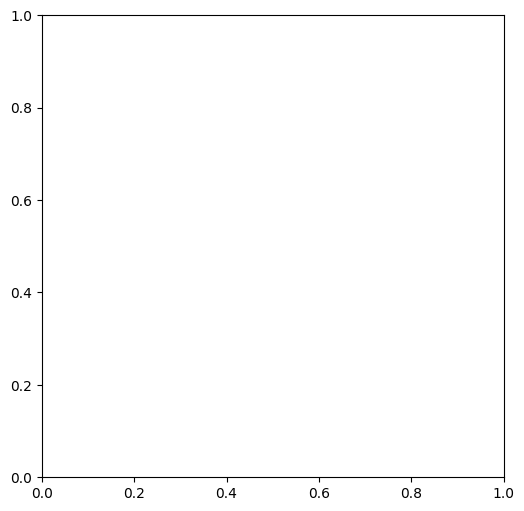

In [83]:
plt.figure(figsize=(10, 6))
plt.imshow(data, cmap='gray', vmin=0, vmax=255)
plt.colorbar(label='Intensity')
plt.title('Sentinel-1 SAR Data Visualization (C-band, VV polarization)')
plt.xlabel('Pixel Column')
plt.ylabel('Pixel Row')
plt.grid(False)  # Disable the grid
plt.show()